<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/bigan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BiGAN includes an encoder E which maps data x to latent representations z in addition to the generator G from the standard GAN framework. The BiGAN discriminator D discriminates not only in data space (x versus G(z)), but jointly in data and latent space (tuples (x, E(x)) versus (G(z), z)), where the latent component is either an encoder output E(x) or a generator input z.

![alt text](https://raphaellederman.github.io/assets/images/bigan.png)

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
!mkdir images
!mkdir saved_models

Using TensorFlow backend.


In [0]:

class BIGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the encoder
        self.encoder = self.build_encoder()

        # The part of the bigan that trains the discriminator and encoder
        self.discriminator.trainable = False

        # Generate image from sampled noise
        z = Input(shape=(self.latent_dim, ))
        img_ = self.generator(z)

        # Encode image
        img = Input(shape=self.img_shape)
        z_ = self.encoder(img)

        # Latent -> img is fake, and img -> latent is valid
        fake = self.discriminator([z, img_])
        valid = self.discriminator([z_, img])

        # Set up and compile the combined model
        # Trains generator to fool the discriminator
        self.bigan_generator = Model([z, img], [fake, valid])
        self.bigan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            optimizer=optimizer)

In [0]:

def build_encoder(self):
    model = Sequential()

    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(self.latent_dim))

    model.summary()

    img = Input(shape=self.img_shape)
    z = model(img)

    return Model(img, z)

BIGAN.build_encoder = build_encoder;
del build_encoder;

In [0]:
def build_generator(self):
    model = Sequential()

    model.add(Dense(512, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))

    model.summary()

    z = Input(shape=(self.latent_dim,))
    gen_img = model(z)

    return Model(z, gen_img)

BIGAN.build_generator = build_generator;
del build_generator;

In [0]:

def build_discriminator(self):

    z = Input(shape=(self.latent_dim, ))
    img = Input(shape=self.img_shape)
    d_in = concatenate([z, Flatten()(img)])

    model = Dense(1024)(d_in)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.5)(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.5)(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.5)(model)
    validity = Dense(1, activation="sigmoid")(model)

    return Model([z, img], validity)

BIGAN.build_discriminator = build_discriminator;
del build_discriminator;

In [0]:
def train(self, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):


        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Sample noise and generate img
        z = np.random.normal(size=(batch_size, self.latent_dim))
        imgs_ = self.generator.predict(z)

        # Select a random batch of images and encode
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        z_ = self.encoder.predict(imgs)

        # Train the discriminator (img -> z is valid, z -> img is fake)
        d_loss_real = self.discriminator.train_on_batch([z_, imgs], valid)
        d_loss_fake = self.discriminator.train_on_batch([z, imgs_], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (z -> img is valid and img -> z is is invalid)
        g_loss = self.bigan_generator.train_on_batch([z, imgs], [valid, fake])

        # Plot the progress
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            self.sample_interval(epoch)

BIGAN.train = train;
del train;

In [0]:

def sample_interval(self, epoch):
    r, c = 5, 5
    z = np.random.normal(size=(25, self.latent_dim))
    gen_imgs = self.generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

BIGAN.sample_interval = sample_interval;
del sample_interval;

In [8]:
bigan = BIGAN()
bigan.train(epochs=40000, batch_size=32, sample_interval=400)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_____________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




0 [D loss: 0.946668, acc: 35.94%] [G loss: 4.189999]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
12274 [D loss: 8.059048, acc: 50.00%] [G loss: 16.118095]
12275 [D loss: 8.059048, acc: 50.00%] [G loss: 15.828402]
12276 [D loss: 8.059048, acc: 50.00%] [G loss: 16.118095]
12277 [D loss: 8.059048, acc: 50.00%] [G loss: 16.118095]
12278 [D loss: 8.059048, acc: 50.00%] [G loss: 16.118095]
12279 [D loss: 8.059091, acc: 50.00%] [G loss: 16.062309]
12280 [D loss: 8.059048, acc: 50.00%] [G loss: 16.021849]
12281 [D loss: 8.059048, acc: 50.00%] [G loss: 16.118095]
12282 [D loss: 8.059048, acc: 50.00%] [G loss: 16.112604]
12283 [D loss: 8.059048, acc: 50.00%] [G loss: 16.083969]
12284 [D loss: 8.059048, acc: 50.00%] [G loss: 16.118095]
12285 [D loss: 8.059054, acc: 50.00%] [G loss: 15.684568]
12286 [D loss: 8.059050, acc: 50.00%] [G loss: 16.118095]
12287 [D loss: 8.059050, acc: 50.00%] [G loss: 15.839833]
12288 [D loss: 8.059050, acc: 50.00%] [G loss: 16.118095]
12289 [D loss: 8.059048, acc: 50.00%] [G loss: 16.118095]
12290 [D loss: 8.0590

KeyboardInterrupt: ignored

images/mnist_0.png	images/mnist_15200.png	images/mnist_4800.png
images/mnist_10000.png	images/mnist_15600.png	images/mnist_5200.png
images/mnist_10400.png	images/mnist_16000.png	images/mnist_5600.png
images/mnist_10800.png	images/mnist_1600.png	images/mnist_6000.png
images/mnist_11200.png	images/mnist_16400.png	images/mnist_6400.png
images/mnist_11600.png	images/mnist_16800.png	images/mnist_6800.png
images/mnist_12000.png	images/mnist_17200.png	images/mnist_7200.png
images/mnist_1200.png	images/mnist_2000.png	images/mnist_7600.png
images/mnist_12400.png	images/mnist_2400.png	images/mnist_8000.png
images/mnist_12800.png	images/mnist_2800.png	images/mnist_800.png
images/mnist_13200.png	images/mnist_3200.png	images/mnist_8400.png
images/mnist_13600.png	images/mnist_3600.png	images/mnist_8800.png
images/mnist_14000.png	images/mnist_4000.png	images/mnist_9200.png
images/mnist_14400.png	images/mnist_400.png	images/mnist_9600.png
images/mnist_14800.png	images/mnist_4400.png


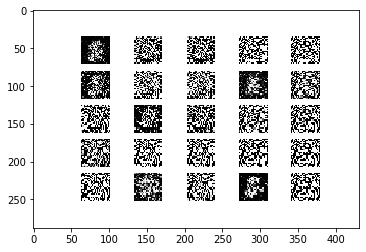

In [10]:
!ls images/*
img = plt.imread("images/mnist_17200.png")
plt.imshow(img)